# Load data

In [46]:
import tensorflow as tf

img_size = (256, 256)  
batch_size = 16

original_train_ds = tf.keras.utils.image_dataset_from_directory(
    "Teeth_Dataset/Training",
    image_size=img_size,
    batch_size=batch_size,
)

original_val_ds = tf.keras.utils.image_dataset_from_directory(
    "Teeth_Dataset/validation",
    image_size=img_size,
    batch_size=batch_size,
)

original_test_ds = tf.keras.utils.image_dataset_from_directory(
    "Teeth_Dataset/testing",
    image_size=img_size,
    batch_size=batch_size,
)

for images, labels in original_train_ds.take(1):  # take 1 batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Labels:", labels.numpy())




Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Image batch shape: (16, 256, 256, 3)
Label batch shape: (16,)
Labels: [3 1 5 2 3 2 2 0 0 0 0 0 0 3 0 3]


In [9]:
print("Class names:", train_ds.class_names)


Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


# Preprocessing 

In [47]:
"""
normalization 
data augmentation   
resize 64

"""


from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),     
    layers.RandomRotation(0.1),          
    layers.RandomZoom(0.1),              
    layers.RandomContrast(0.1),          
])

def preprocess_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0   # normalize
    image = data_augmentation(image)             # augment
    return image, label

def preprocess_test(image, label):
    image = tf.cast(image, tf.float32) / 255.0   # normalize only
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = original_train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE)
val_ds   = original_val_ds.map(preprocess_test, num_parallel_calls=AUTOTUNE)
test_ds  = original_test_ds.map(preprocess_test, num_parallel_calls=AUTOTUNE)


    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0044501].


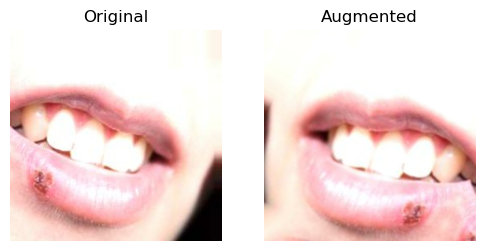

In [ ]:

for raw_images, raw_labels in original_train_ds.take(1):   
    image = raw_images[0]  
    label = raw_labels[0]
    break

plt.figure(figsize=(6, 3))

# Original
plt.subplot(1, 2, 1)
plt.imshow(image.numpy().astype("uint8"))
plt.title("Original")
plt.axis("off")

augmented_image, _ = preprocess_train(tf.expand_dims(image, axis=0), label)  # add batch dim
augmented_image = augmented_image[0]  # remove batch dim again
plt.subplot(1, 2, 2)
plt.imshow(augmented_image.numpy())
plt.title("Augmented")
plt.axis("off")

plt.show()


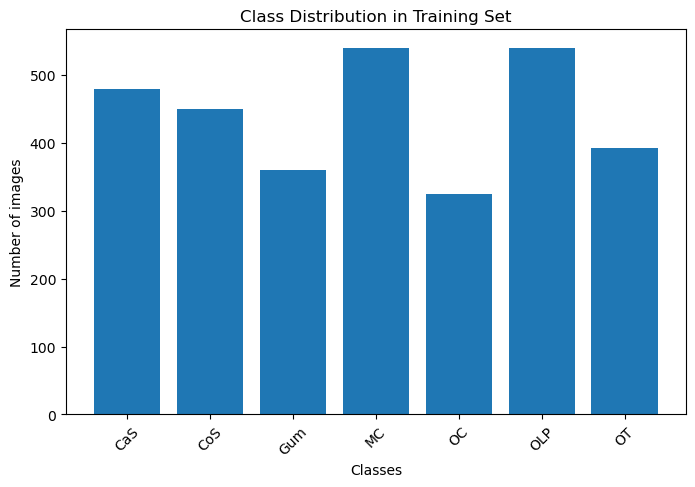

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names
class_names = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

counts = np.zeros(len(class_names))
for images, labels in train_ds:
    for label in labels.numpy():
        counts[label] += 1

# Plot
plt.figure(figsize=(8, 5))
plt.bar(class_names, counts)
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()


In [15]:
resize = tf.keras.layers.Resizing(64, 64)

train_ds = train_ds.map(lambda x, y: (resize(x), y))
val_ds   = val_ds.map(lambda x, y: (resize(x), y))
test_ds  = test_ds.map(lambda x, y: (resize(x), y))


In [18]:
batch = train_ds.take(1)
for images , labels in batch:
    for i in range(1):
        print(images.shape)

(16, 64, 64, 3)


# Model Stage

In [38]:
import tensorflow as tf
from tensorflow.keras import models, layers

num_of_classes = 7

model = models.Sequential([
    layers.Input(shape=(64,64,3)),

    # block 1 of conv
    layers.Conv2D(32,(5,5) , activation="relu" , padding="same"),
    layers.MaxPooling2D((2,2)),

    # block 2 of conv
    layers.Conv2D(64 , (5,5) , activation="relu" , padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128 , activation="relu"),
    layers.Dropout(0.3),
    
    layers.Dense(64 , activation="relu"),
    layers.Dropout(0.1),

    layers.Dense(num_of_classes , activation="softmax")
])


model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'],
)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,159,687 (8.24 MB)

 Trainable params: 2,159,687 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(
    train_ds ,
    validation_data = val_ds,
    batch_size = 32,
    epochs = 40
)


Epoch 1/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - accuracy: 0.1616 - loss: 1.9660 - val_accuracy: 0.1790 - val_loss: 1.9076
Epoch 2/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 30s 153ms/step - accuracy: 0.2254 - loss: 1.8586 - val_accuracy: 0.2928 - val_loss: 1.7415
Epoch 3/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 30s 151ms/step - accuracy: 0.3298 - loss: 1.7494 - val_accuracy: 0.3268 - val_loss: 1.7910
Epoch 4/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 30s 150ms/step - accuracy: 0.3350 - loss: 1.6750 - val_accuracy: 0.4494 - val_loss: 1.5001
Epoch 5/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.3873 - loss: 1.5685 - val_accuracy: 0.4708 - val_loss: 1.3878
Epoch 6/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 42s 211ms/step - accuracy: 0.4346 - loss: 1.4993 - val_accuracy: 0.4329 - val_loss: 1.4986
Epoch 7/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 41s 208ms/step - accuracy: 0.4314 - loss: 1.4977 - val_accuracy: 0.5574 - val_loss: 1.2190
Epoch 8/40
193/193 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - accuracy: 0.4711 - loss: 1

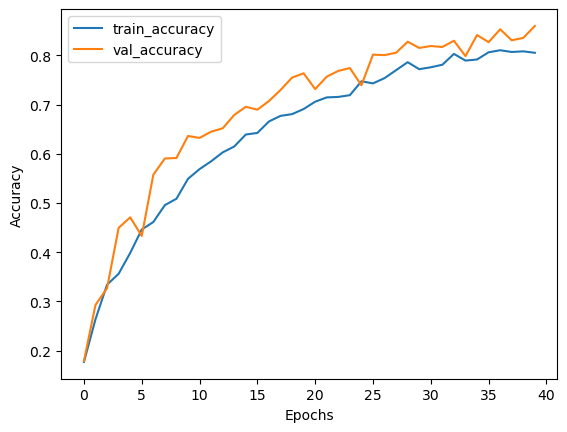

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [41]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8413 - loss: 0.4466
Test Accuracy: 0.8492
Test Loss: 0.4317
